In [1]:
#packages 
library(ggplot2)
library(dplyr)
library(forecast)
library(MLmetrics)

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
"package 'MLmetrics' was built under R version 3.6.3"
Attaching package: 'MLmetrics'

The following object is masked from 'package:base':

    Recall



# read data

In [2]:
df <- read.csv('Jakarta.csv', header=TRUE)

# prelim analysis 

In [3]:
head(df)
sapply(df, class)
nrow(df)
ncol(df)
summary(df)

,Call,City.Municipality
,<fct>,<fct>
1,31/12/2018 22:31:28,JAKARTA TIMUR
2,31/12/2018 23:46:09,JAKARTA TIMUR
3,01/01/2019 00:12:30,JAKARTA TIMUR
4,01/01/2019 01:16:56,JAKARTA TIMUR
5,01/01/2019 01:21:18,JAKARTA BARAT
6,01/01/2019 01:32:10,JAKARTA TIMUR


Call City.Municipality 
         "factor"          "factor"

[1] 22540

[1] 2

                  Call                   City.Municipality
 23/05/2019 11:43:44:    7   JAKARTA PUSAT        :5503   
 01/02/2019 00:30:00:    3   JAKARTA BARAT        :5201   
 01/02/2019 00:01:19:    2   JAKARTA TIMUR        :4505   
 01/02/2019 00:10:00:    2   JAKARTA SELATAN      :3633   
 01/02/2019 00:36:57:    2   JAKARTA UTARA        :2974   
 01/02/2019 00:45:36:    2   JAKARTA PUSAT (KIARA): 124   
 (Other)            :22522   (Other)              : 600   

# Data cleaning

### Missing values?

In [4]:
#check for any NA values
for (i in 1:ncol(df)) {
    print(anyNA(df[,i]))
    print(i)
    }

[1] FALSE
[1] 1
[1] FALSE
[1] 2


### convert `call` to date

In [5]:
# use lubridate from tidyverse package
library(lubridate)

df$Call <- dmy_hms(df$Call)

Warning message:
"package 'lubridate' was built under R version 3.6.3"
Attaching package: 'lubridate'

The following objects are masked from 'package:base':

    date, intersect, setdiff, union



### Duplicate rows

In [6]:
nrow(df[duplicated(df),])

[1] 50

### Spelling inconsistencies in `City.Municipality`

https://www.linkedin.com/learning/cleaning-bad-data-in-r/inconsistent-spellings?u=35392996

In [7]:
table(df$City.Municipality)


                            BANDUNG                              BEKASI 
                                  4                                  47 
                       BEKASI BARAT                               BOGOR 
                                  1                                   9 
                             BREBES                            DENPASAR 
                                  1                                   1 
                              DEPOK                             DEPOK   
                                 38                                   2 
                     JAAKARTA UTARA                       JAAKRTA BARAT 
                                  1                                   1 
                      JAJARTA BARAT                        JAKARA PUSAT 
                                  1                                   1 
                      JAKARAT PUSAT                     JAKARAT SELATAN 
                                  2               

In [8]:
#BEKASI 
bekasi <- df %>%
    filter(grepl('BEKASI', City.Municipality)) %>%
    select(City.Municipality) %>%
    unique() %>%
    pull(City.Municipality)

for (i in df$City.Municipality){
    if (i %in% bekasi) {
        df$City.Municipality[df$City.Municipality== i] <- 'BEKASI'
    }
}

In [9]:
#BOGOR
bogor <- df %>%
    filter(grepl('BOGOR', City.Municipality)) %>%
    select(City.Municipality) %>%
    unique() %>%
    pull(City.Municipality)

for (i in df$City.Municipality){
    if (i %in% bogor) {
        df$City.Municipality[df$City.Municipality== i] <- 'BOGOR'
    }
}

In [10]:
# DEPOK
depok <- df %>%
    filter(grepl('DEPOK', City.Municipality)) %>%
    select(City.Municipality) %>%
    unique() %>%
    pull(City.Municipality)

for (i in df$City.Municipality){
    if (i %in% depok) {
        df$City.Municipality[df$City.Municipality== i] <- 'DEPOK'
    }
}

In [11]:
# jakarta utara
jak_utara <- df %>%
    filter(grepl('UTAR', City.Municipality)) %>%
    select(City.Municipality) %>%
    unique() %>%
    pull(City.Municipality)

for (i in df$City.Municipality){
    if (i %in% jak_utara) {
        df$City.Municipality[df$City.Municipality== i] <- 'JAKARTA UTARA'
    }
}

In [12]:
#JAKARTA BARAT
jak_barat <- df %>%
    filter(grepl('BAR', City.Municipality)) %>%
    filter(City.Municipality!='KALIMANTAN BARAT') %>%
    filter(City.Municipality!='PEJATEN BARAT') %>%
    select(City.Municipality) %>%
    unique() %>%
    pull(City.Municipality)

for (i in df$City.Municipality){
    if (i %in% jak_barat) {
        df$City.Municipality[df$City.Municipality== i] <- 'JAKARTA BARAT'
    }
}

In [13]:
#JAKARTA PUSAT
jak_pusat <- df %>%
    filter(grepl('PUS', City.Municipality)) %>%
    filter(City.Municipality!='PUSKESMAS') %>%
    filter(City.Municipality!='RS PUSDIKKES') %>%
    select(City.Municipality) %>%
    unique() %>%
    pull(City.Municipality)

for (i in df$City.Municipality){
    if (i %in% jak_pusat) {
        df$City.Municipality[df$City.Municipality== i] <- 'JAKARTA PUSAT'
    }
}

In [14]:
#JAKARTA SELATAN
jak_selatan <- df %>%
    filter(grepl(paste(c('SEL','A S'), collapse="|"), City.Municipality)) %>%
    filter(City.Municipality!='TANGASTOENTERITISRANG SELATAN') %>%
    filter(City.Municipality!='KOTA TANGASTOENTERITISRANG SELATAN') %>%
    filter(City.Municipality!='TANGERANG SELATAN') %>%
    filter(City.Municipality!='KOTA TANGERANG SELATAN') %>%
    select(City.Municipality) %>%
    unique() %>%
    pull(City.Municipality)

for (i in df$City.Municipality){
    if (i %in% jak_selatan) {
        df$City.Municipality[df$City.Municipality== i] <- 'JAKARTA SELATAN'
    }
}

In [15]:
#JAKARTA TIMUR
jak_timur <- df %>%
    filter(grepl(paste(c('TIM','A T'), collapse="|"), City.Municipality)) %>%
    filter(City.Municipality!='KOTA TANGASTOENTERITISRANG SELATAN') %>%
    filter(City.Municipality!='KOTA TANGASTOENTERITISRANG') %>%
    filter(City.Municipality!='KOTA TANGERANG') %>%
    filter(City.Municipality!='KOTA TANGERANG SELATAN') %>%
    select(City.Municipality) %>%
    unique() %>%
    pull(City.Municipality)

for (i in df$City.Municipality){
    if (i %in% jak_timur) {
        df$City.Municipality[df$City.Municipality== i] <- 'JAKARTA TIMUR'
    }
}

In [16]:
# TANGERANG SELATAN
tan_selatan <- df %>%
    filter(grepl('SEL', City.Municipality)) %>%
    filter(City.Municipality!='JAKARTA SELATAN') %>%
    select(City.Municipality) %>%
    unique() %>%
    pull(City.Municipality)

for (i in df$City.Municipality){
    if (i %in% tan_selatan) {
        df$City.Municipality[df$City.Municipality== i] <- 'TANGERANG SELATAN'
    }
}

In [17]:
# KEPULAUAN SERIBU
kep_seribu <- df %>%
    filter(grepl('KEP', City.Municipality)) %>%
    select(City.Municipality) %>%
    unique() %>%
    pull(City.Municipality)

for (i in df$City.Municipality){
    if (i %in% kep_seribu) {
        df$City.Municipality[df$City.Municipality== i] <- 'KEPULAUAN SERIBU'
    }
}

In [18]:
# TANGERANG
tangerang <- df %>%
    filter(grepl('TANG', City.Municipality)) %>%
    filter(City.Municipality!='TANGERANG SELATAN') %>%
    select(City.Municipality) %>%
    unique() %>%
    pull(City.Municipality)

for (i in df$City.Municipality){
    if (i %in% tangerang) {
        df$City.Municipality[df$City.Municipality== i] <- 'TANGERANG'
    }
}

In [19]:
table(df$City.Municipality)


                            BANDUNG                              BEKASI 
                                  4                                  63 
                       BEKASI BARAT                               BOGOR 
                                  0                                  10 
                             BREBES                            DENPASAR 
                                  1                                   1 
                              DEPOK                             DEPOK   
                                 42                                   0 
                     JAAKARTA UTARA                       JAAKRTA BARAT 
                                  0                                   0 
                      JAJARTA BARAT                        JAKARA PUSAT 
                                  0                                   0 
                      JAKARAT PUSAT                     JAKARAT SELATAN 
                                  0               

### Summary

In [20]:
head(df)
sapply(df, class)
nrow(df)
ncol(df)
summary(df)

,Call,City.Municipality
,<dttm>,<fct>
1,2018-12-31 22:31:28,JAKARTA TIMUR
2,2018-12-31 23:46:09,JAKARTA TIMUR
3,2019-01-01 00:12:30,JAKARTA TIMUR
4,2019-01-01 01:16:56,JAKARTA TIMUR
5,2019-01-01 01:21:18,JAKARTA BARAT
6,2019-01-01 01:32:10,JAKARTA TIMUR


$Call
[1] "POSIXct" "POSIXt" 

$City.Municipality
[1] "factor"

[1] 22540

[1] 2

      Call                           City.Municipality
 Min.   :2018-12-31 22:31:28   JAKARTA PUSAT  :5683   
 1st Qu.:2019-02-07 23:32:10   JAKARTA BARAT  :5220   
 Median :2019-03-17 13:20:48   JAKARTA TIMUR  :4554   
 Mean   :2019-03-17 13:44:11   JAKARTA SELATAN:3649   
 3rd Qu.:2019-04-24 13:23:53   JAKARTA UTARA  :2991   
 Max.   :2019-05-31 23:46:16   TANGERANG      :  75   
                               (Other)        : 368   

In [21]:
#mean number of calls
mean(data.frame(table(date(df$Call)))[2:152,2])

[1] 149.2583

# Visual EDA

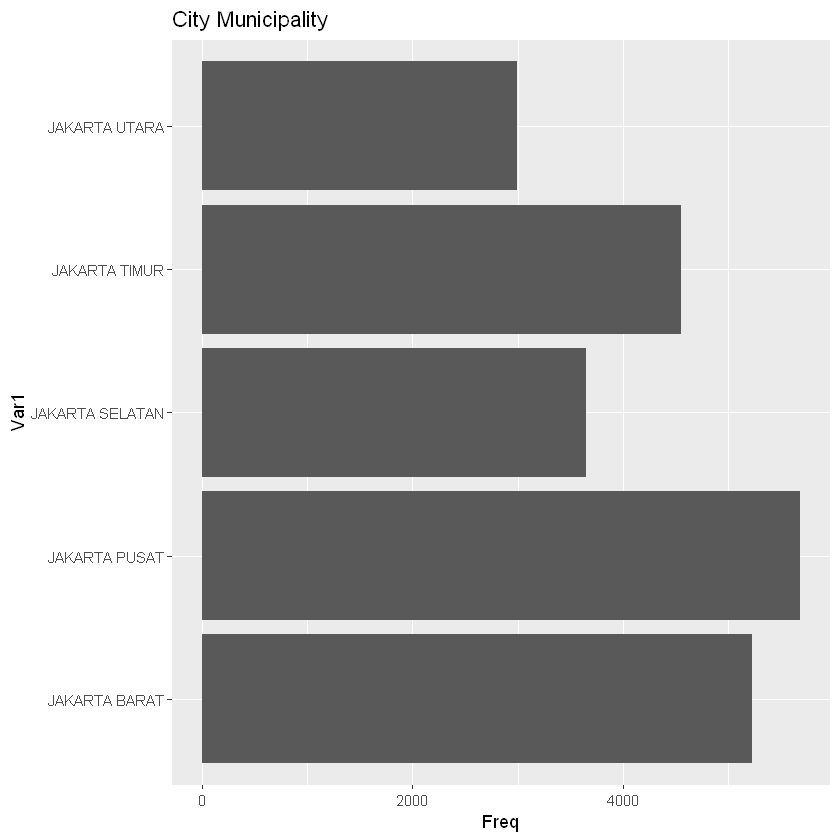

In [22]:
places <- data.frame(table(df$City.Municipality))
places <- places[places$Freq >100,]
# plot as horizontal bar plot instead
p<-ggplot(data=places, aes(x=Var1, y=Freq)) +
  geom_bar(stat="identity") +
    ggtitle('City Municipality')
p + coord_flip()

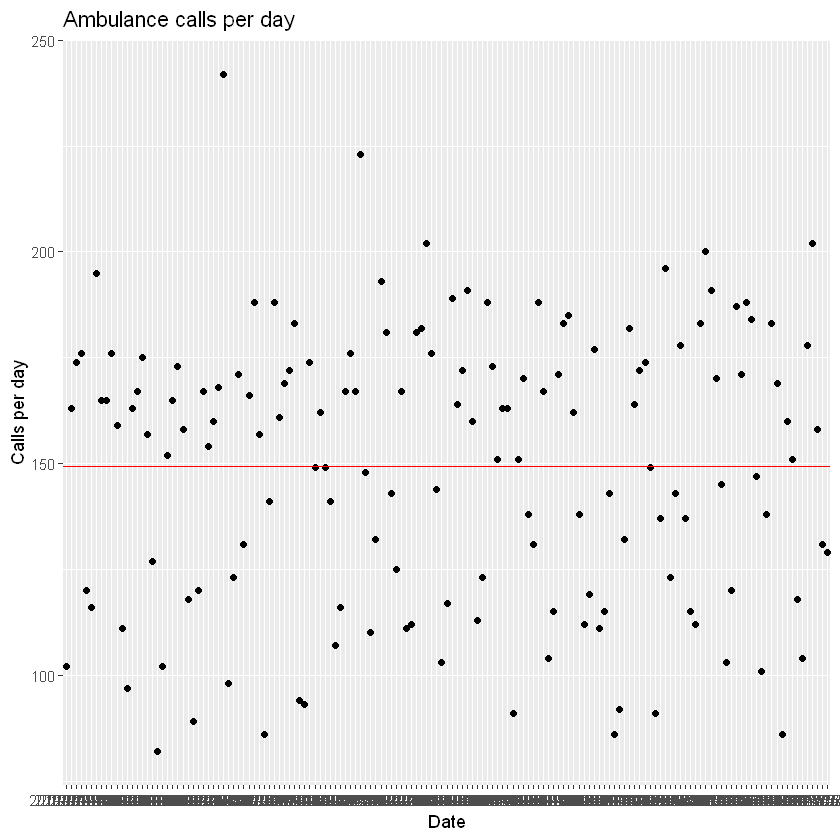

In [23]:
ggplot(data.frame(table(date(df$Call)))[2:152,], aes(Var1,Freq)) +
           geom_point(na.rm=TRUE)+ 
           ggtitle("Ambulance calls per day") +
           xlab("Date") + ylab("Calls per day") + 
           geom_hline(yintercept = mean(data.frame(table(date(df$Call)))[2:152,2]), color="red")


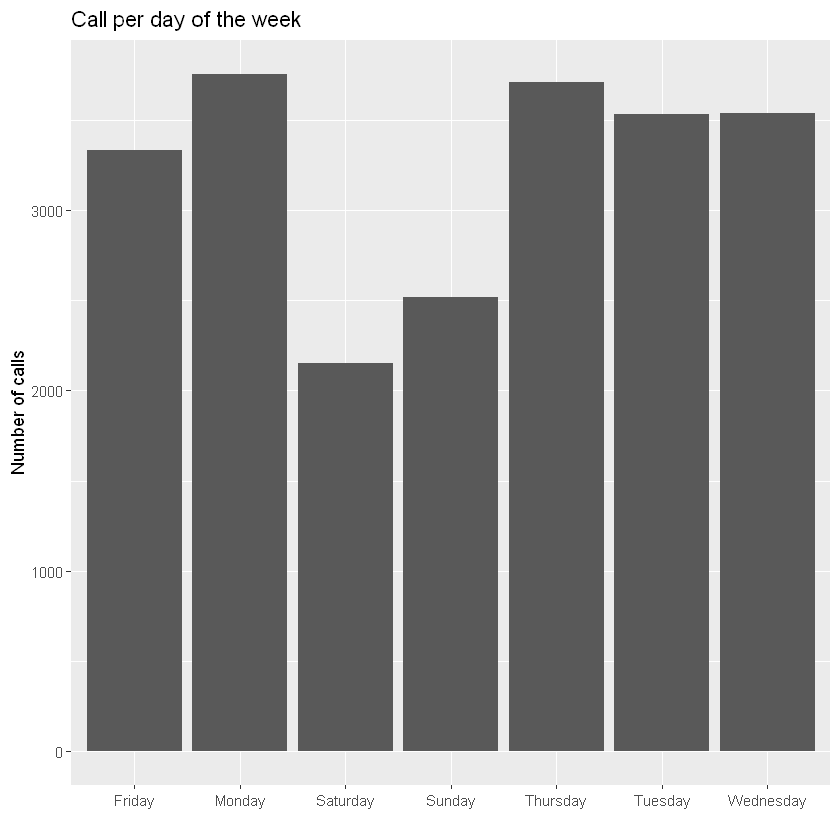

In [24]:
# plot histogram of calls per day
calls_per_day <- data.frame(table(weekdays(df$Call)))
p<-ggplot(data=calls_per_day, aes(x=Var1, y=Freq)) +
  geom_bar(stat="identity") +
    ggtitle('Call per day of the week') + xlab("") + ylab("Number of calls") 
p

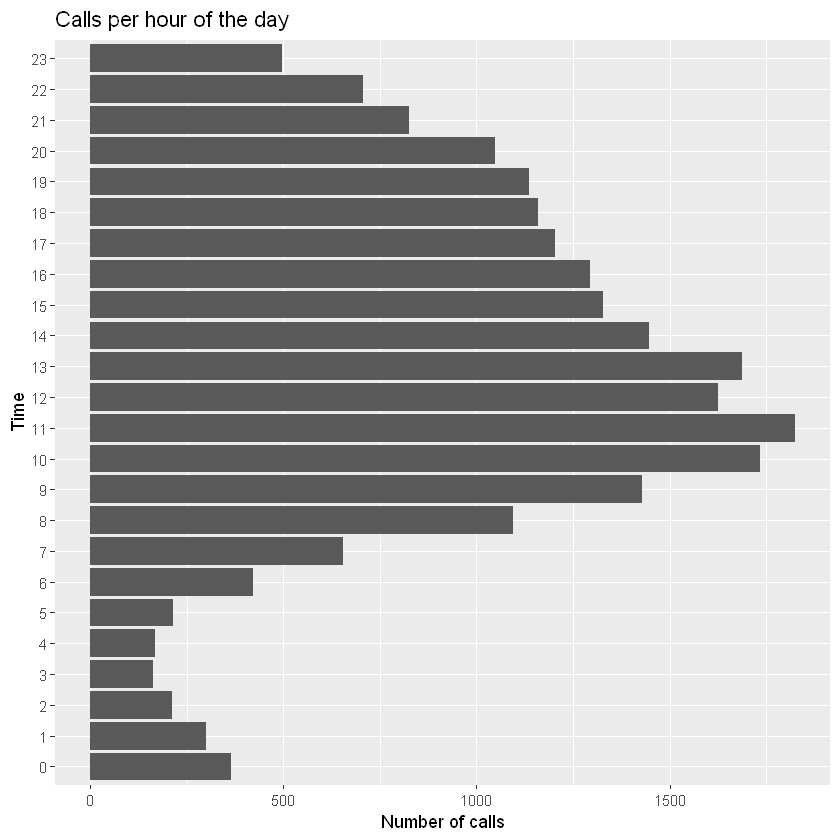

In [25]:
calls_per_hour <- data.frame(table(hour(df$Call)))
p<-ggplot(data=calls_per_hour, aes(x=Var1, y=Freq)) +
  geom_bar(stat="identity") +
    ggtitle('Calls per hour of the day') + xlab("Time") + ylab("Number of calls") 
p + coord_flip()

# Time series 

In [26]:
library(xts)

dates <- as.Date("2019-01-01")+(0:(length(data.frame(table(date(df$Call)))[2:152,2])-1))

time_series <- xts(data.frame(table(date(df$Call)))[2:152,2],dates,frequency=7)

Warning message:
"package 'xts' was built under R version 3.6.3"Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last



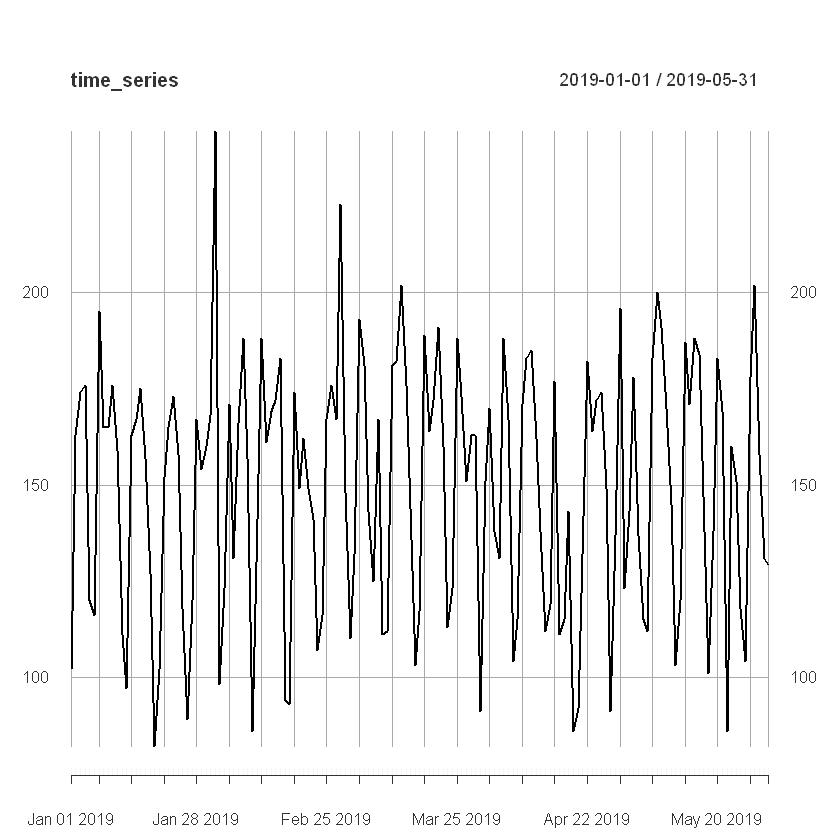

In [27]:
plot(time_series)

# Data split

In [28]:
train <- head(time_series, round(length(time_series) * 0.7))
h <- length(time_series) - length(train)
test <- tail(time_series, h)

# Dickey-fuller test

In [29]:
library(tseries)

adf.test(train)

Warning message:
"package 'tseries' was built under R version 3.6.3"Warning message in adf.test(train):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  train
Dickey-Fuller = -8.0973, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


P-value of 0.01 is less than the significance level of alpha = 0.05. We reject the null hypothesis and conclude: the Dickey-Fuller test suggests the time series is stationary.

# ACF and PACF

### ACF


Autocorrelations of series 'train', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000  0.201 -0.322 -0.227 -0.177 -0.209  0.122  0.546  0.142 -0.266 -0.175 
    11     12     13     14     15     16     17     18     19     20 
-0.197 -0.242  0.179  0.558  0.105 -0.278 -0.145 -0.138 -0.250  0.124 

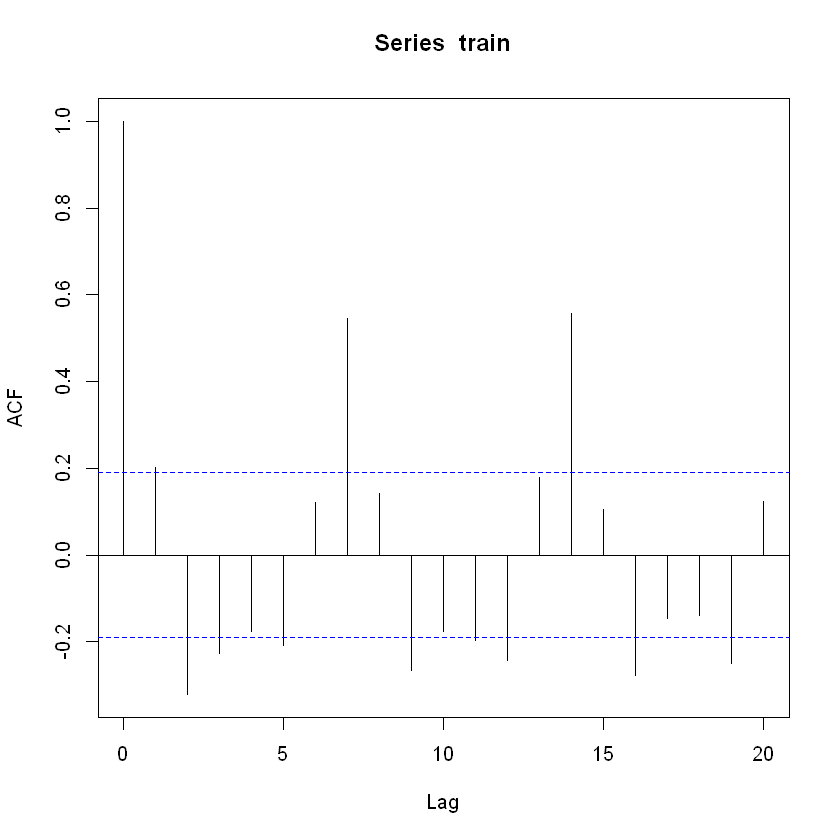

In [30]:
acf(train)
acf(train,plot=FALSE)

ACF plot suggests weekly seasonality present, as there are significant lags at 7 and 14

### PACF


Partial autocorrelations of series 'train', by lag

     1      2      3      4      5      6      7      8      9     10     11 
 0.201 -0.377 -0.076 -0.268 -0.290  0.049  0.380 -0.074 -0.035  0.017 -0.197 
    12     13     14     15     16     17     18     19     20 
-0.179  0.115  0.204 -0.093 -0.006  0.037 -0.052 -0.143  0.008 

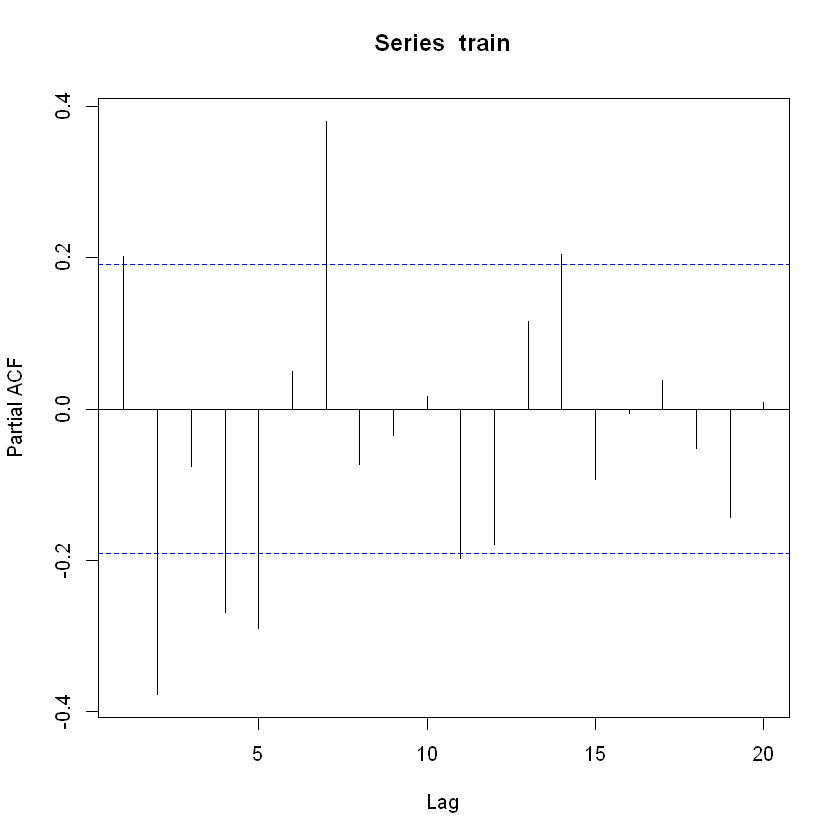

In [31]:
pacf(train)
pacf(train,plot=FALSE)

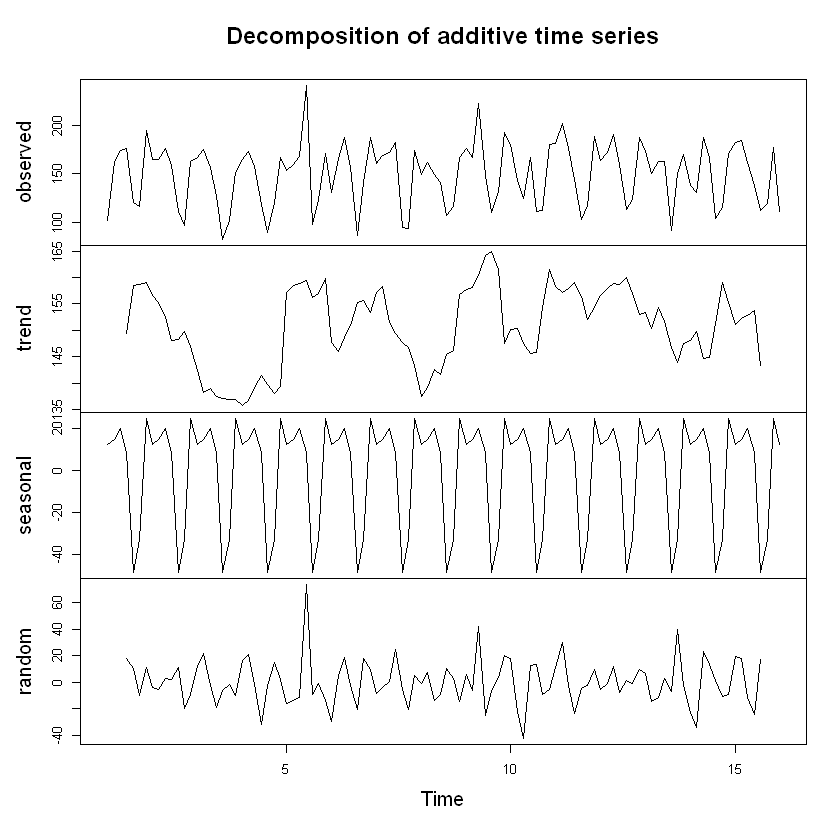

In [32]:
plot(decompose(ts(as.numeric(train), frequency=7))) 

## De-seasonalize

Since the training set have seasonality present we will apply De-seasonalize via the `stl` and `seasadj` functions to the training set and then the full data set. 

In [33]:
library(stats)

decomposed <-stl(ts(as.numeric(train), frequency=7), s.window="periodic", robust=TRUE)
train <- seasadj(decomposed,"multiplicative")

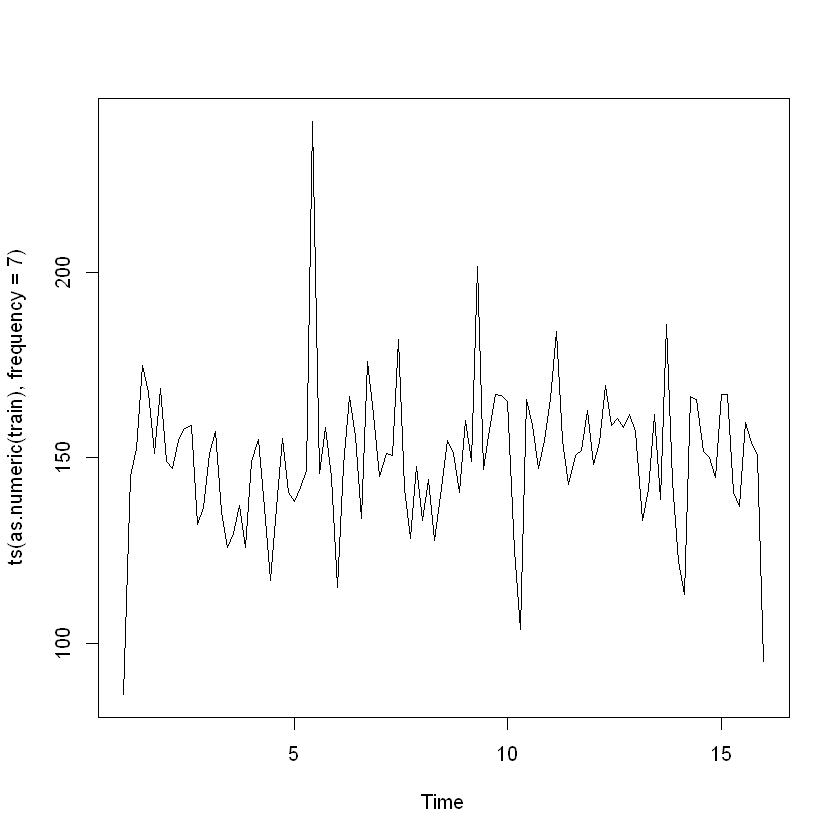

In [34]:
plot(ts(as.numeric(train), frequency=7))

In [35]:
dates <- as.Date("2019-01-01")+(0:(length(ts(as.numeric(train), frequency=7))-1))

train <- xts(ts(as.numeric(train), frequency=7),dates,frequency=7)

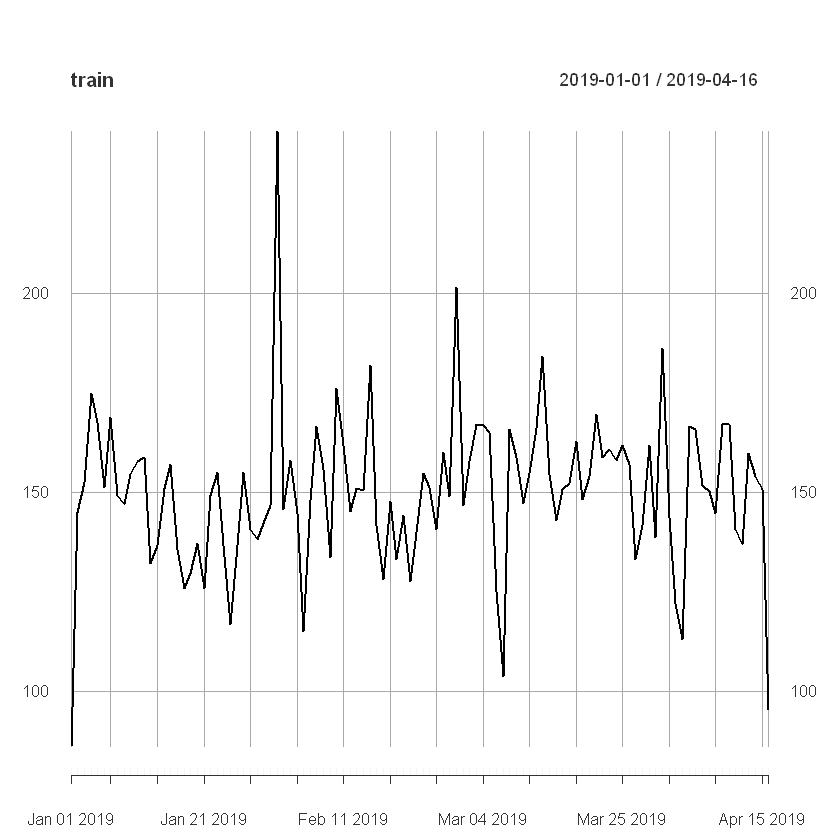

In [36]:
plot(train)

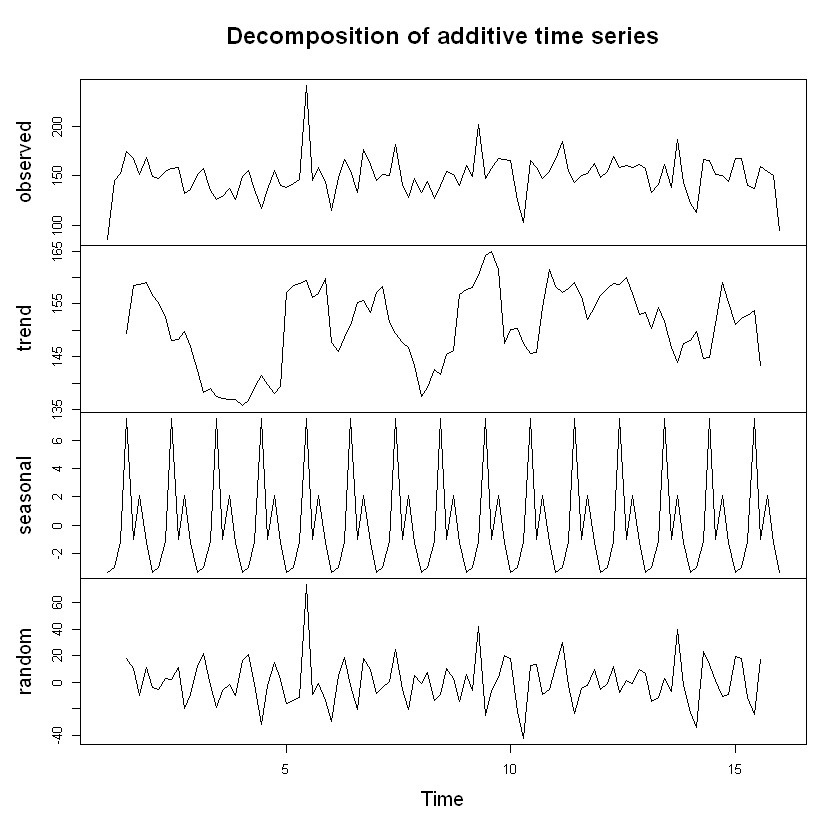

In [37]:
plot(decompose(ts(as.numeric(train), frequency=7))) 


Autocorrelations of series 'train', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000  0.118 -0.082 -0.082  0.024  0.130 -0.128 -0.156  0.023  0.052  0.006 
    11     12     13     14     15     16     17     18     19     20 
-0.113 -0.001  0.083 -0.008 -0.046 -0.051  0.061  0.061 -0.045 -0.051 

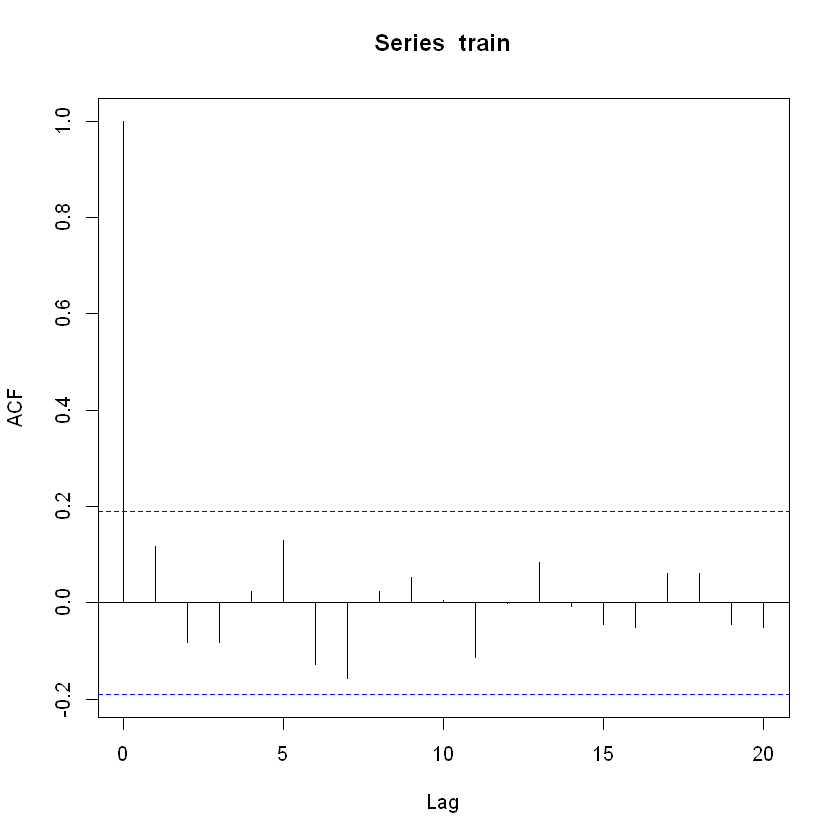

In [38]:
acf(train)
acf(train,plot=FALSE)


Partial autocorrelations of series 'train', by lag

     1      2      3      4      5      6      7      8      9     10     11 
 0.118 -0.097 -0.062  0.035  0.114 -0.165 -0.103  0.057  0.000 -0.031 -0.067 
    12     13     14     15     16     17     18     19     20 
 0.043  0.023 -0.052 -0.011 -0.012  0.032  0.008 -0.023 -0.017 

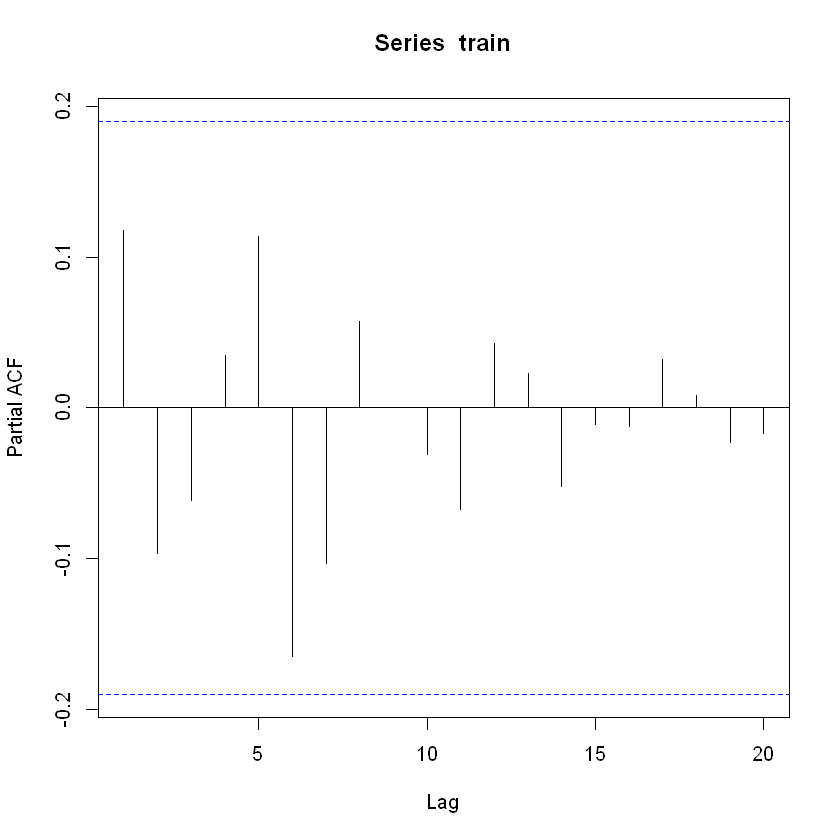

In [39]:
pacf(train)
pacf(train,plot=FALSE)

### Deseasonalize the full data set

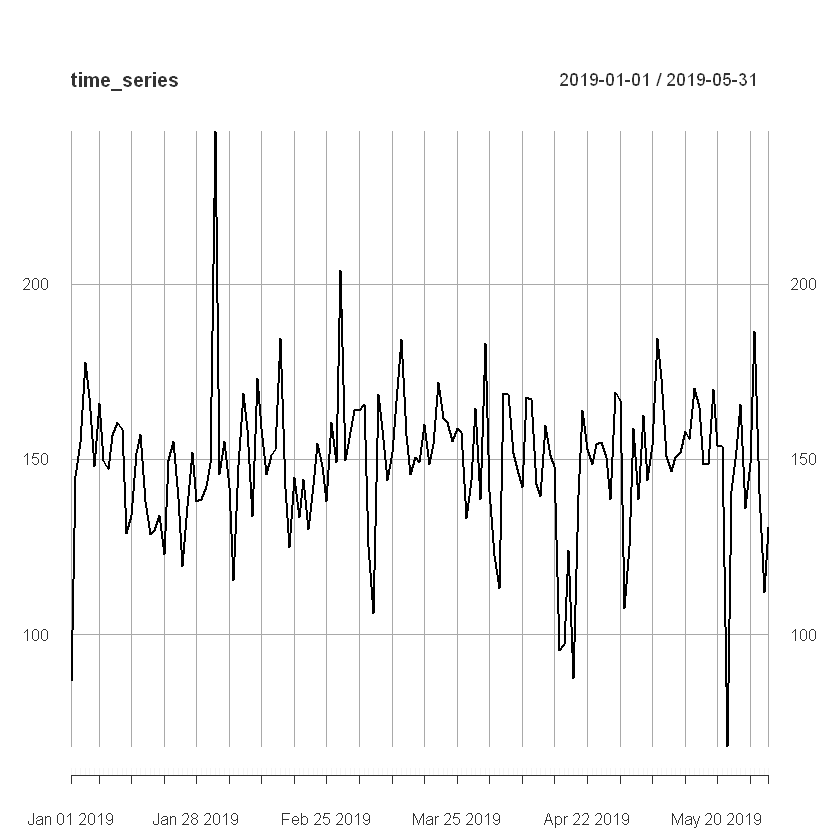

In [83]:
decomposed <-stl(ts(as.numeric(time_series), frequency=7), s.window="periodic", robust=TRUE)
time_series <- seasadj(decomposed,"multiplicative")
dates <- as.Date("2019-01-01")+(0:(length(ts(as.numeric(time_series), frequency=7))-1))

time_series <- xts(ts(as.numeric(time_series), frequency=7),dates,frequency=7)
plot(time_series)

# Auto arima

In [41]:
arima_model <- auto.arima(train,approximation=FALSE,trace=TRUE,stepwise=FALSE)#,max.p = 7,max.q = 5,max.d = 2)
summary(arima_model)


 ARIMA(0,0,0) with zero mean     : 1366.724
 ARIMA(0,0,0) with non-zero mean : 937.4932
 ARIMA(0,0,1) with zero mean     : 1248.945
 ARIMA(0,0,1) with non-zero mean : 937.4446
 ARIMA(0,0,2) with zero mean     : 1183.074
 ARIMA(0,0,2) with non-zero mean : 939.141
 ARIMA(0,0,3) with zero mean     : 1125.052
 ARIMA(0,0,3) with non-zero mean : 940.8365
 ARIMA(0,0,4) with zero mean     : 1105.688
 ARIMA(0,0,4) with non-zero mean : 942.3865
 ARIMA(0,0,5) with zero mean     : 1091.36
 ARIMA(0,0,5) with non-zero mean : 942.3256
 ARIMA(1,0,0) with zero mean     : 990.0803
 ARIMA(1,0,0) with non-zero mean : 937.8436
 ARIMA(1,0,1) with zero mean     : Inf
 ARIMA(1,0,1) with non-zero mean : 939.3591
 ARIMA(1,0,2) with zero mean     : Inf
 ARIMA(1,0,2) with non-zero mean : 940.7908
 ARIMA(1,0,3) with zero mean     : Inf
 ARIMA(1,0,3) with non-zero mean : 942.9679
 ARIMA(1,0,4) with zero mean     : Inf
 ARIMA(1,0,4) with non-zero mean : 943.5065
 ARIMA(2,0,0) with zero mean     : Inf
 ARIMA(2,0,0) 

We can see that the best fitting model is:ARIMA(0,0,1)

## ARIMA fit


Call:
arima(x = train, order = c(0, 0, 1))

Coefficients:
         ma1  intercept
      0.1687   149.6636
s.e.  0.1105     2.2205

sigma^2 estimated as 382.5:  log likelihood = -465.6,  aic = 937.21


Warning message in eval(expr, envir, enclos):
"Incompatible methods ("Ops.xts", "Ops.ts") for "-""

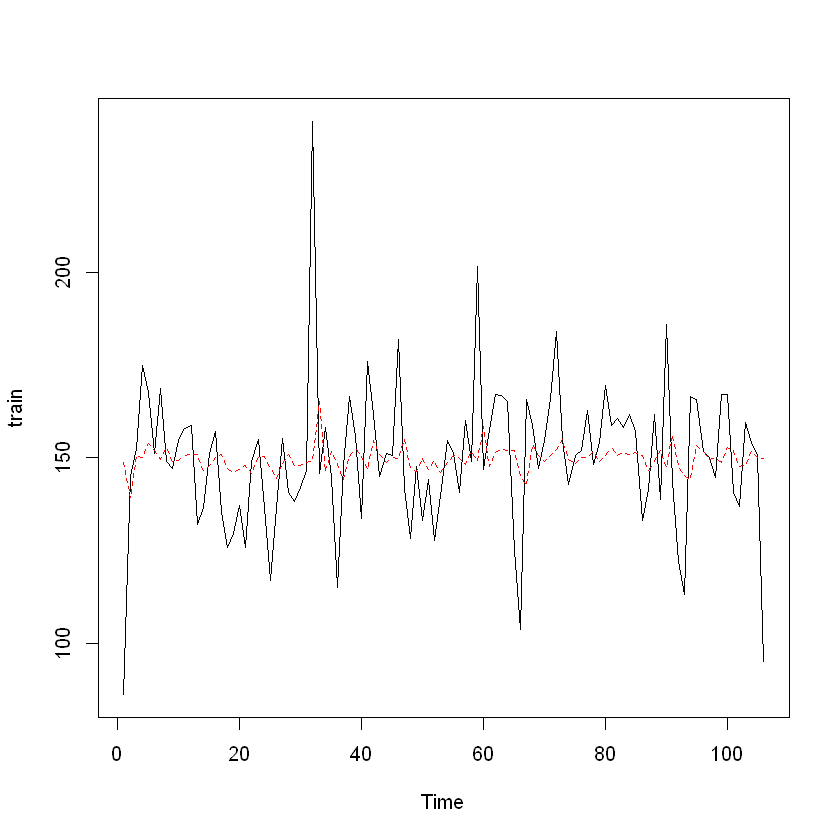

In [42]:
# Fit the AR model to time series
AR <- arima(train,order=c(0,0,1))
print(AR)

# Run the following commands to plot the series and fitted values
ts.plot(train)
AR_fitted <- train - residuals(AR)
points(AR_fitted, type = "l", col = 2, lty = 2)

### Check the residuals


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with non-zero mean
Q* = 8.3417, df = 8, p-value = 0.4008

Model df: 2.   Total lags used: 10



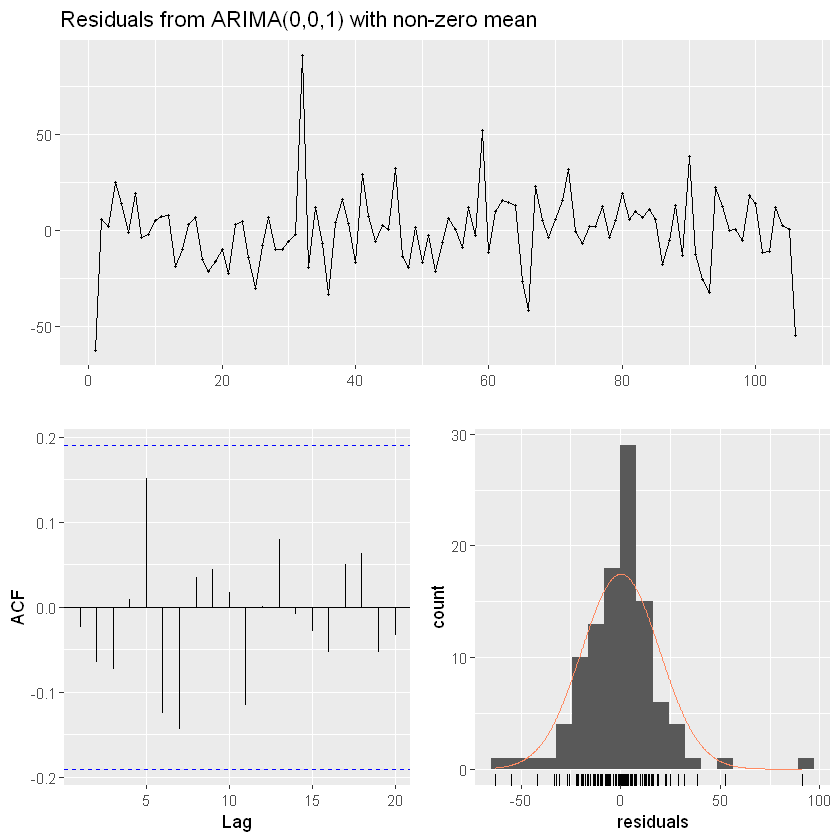

In [43]:
checkresiduals(AR)

In [44]:
shapiro.test(AR$residuals)


	Shapiro-Wilk normality test

data:  AR$residuals
W = 0.93152, p-value = 3.689e-05


The ACF plot of the residuals from the ARIMA(0,0,1) model shows that not all autocorrelations are within the threshold limits, indicating that the residuals are not behaving like white noise. A portmanteau test returns a small p-value, also suggesting that the residuals are not white noise. 

However, the residuals are not normally distributed according to the small p-value obtained in the Shapiro Wilk test. I will try the Box-Cox transformation to see if it will make the residuals normally distributed.

##  ARIMA Forecast

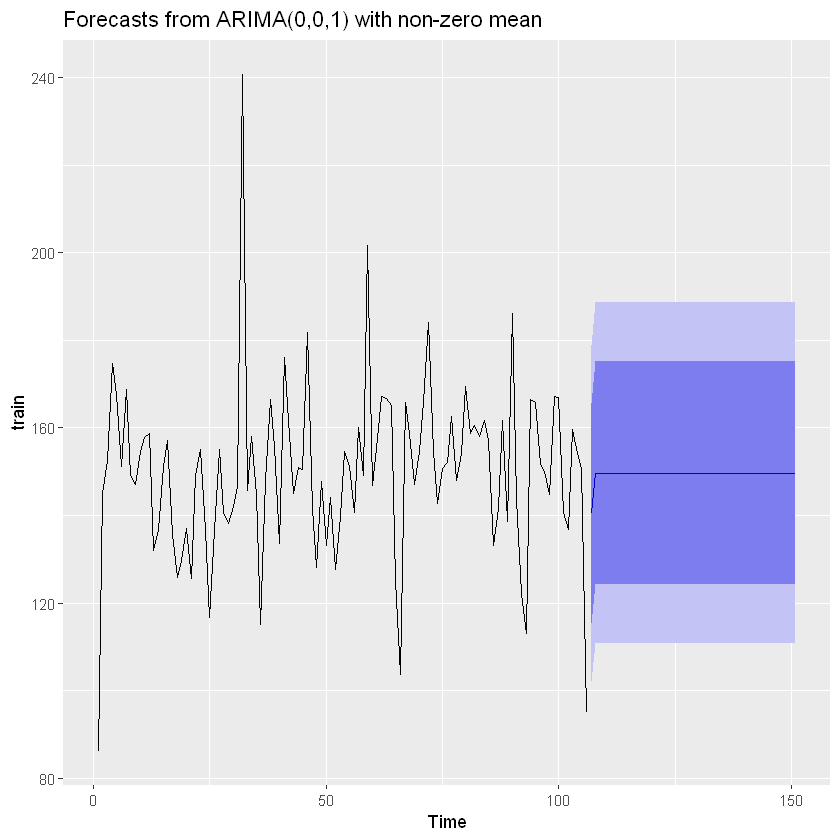

In [45]:
for_AR <- forecast(AR,h=45)
autoplot(for_AR)

# Native 

In [46]:
library(forecast)
naive_mod <- naive(train, h = 45)
summary(naive_mod)


Forecast method: Naive method

Model Information:
Call: naive(y = train, h = 45) 

Residual sd: 25.0709 

Error measures:
                     ME     RMSE      MAE       MPE     MAPE MASE       ACF1
Training set 0.08571429 25.07091 17.79891 -1.252983 11.93192    1 -0.3254875

Forecasts:
    Point Forecast       Lo 80    Hi 80       Lo 95    Hi 95
107       95.08775   62.958082 127.2174   45.949664 144.2258
108       95.08775   49.649538 140.5260   25.596002 164.5795
109       95.08775   39.437533 150.7380    9.978088 180.1974
110       95.08775   30.828415 159.3471   -3.188422 193.3639
111       95.08775   23.243629 166.9319  -14.788351 204.9639
112       95.08775   16.386459 173.7890  -25.275488 215.4510
113       95.08775   10.080640 180.0949  -34.919406 225.0949
114       95.08775    4.211327 185.9642  -43.895746 234.0712
115       95.08775   -1.301253 191.4768  -52.326508 242.5020
116       95.08775   -6.515180 196.6907  -60.300522 250.4760
117       95.08775  -11.474302 201.6498 

### Check residuals


	Ljung-Box test

data:  Residuals from Naive method
Q* = 23.496, df = 10, p-value = 0.009056

Model df: 0.   Total lags used: 10



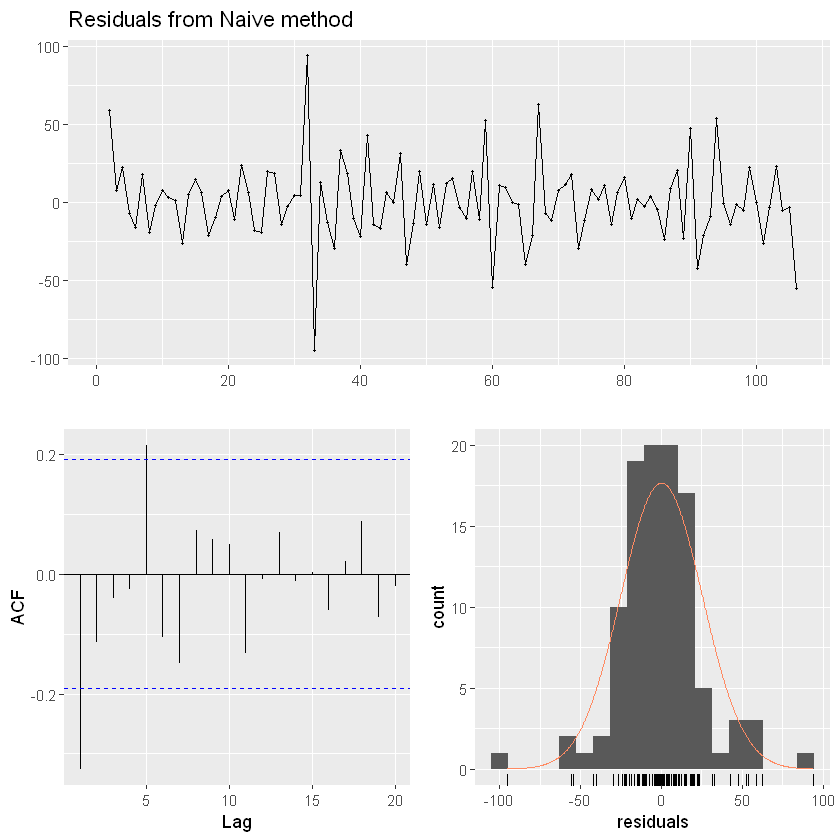

In [47]:
checkresiduals(naive_mod)

The ACF plot of the residuals from the Native model shows that not all autocorrelations are within the threshold limits, indicating that the residuals are not behaving like white noise. A portmanteau test returns a small p-value, also suggesting that the residuals are not white noise.

In [48]:
shapiro.test(naive_mod$residuals)


	Shapiro-Wilk normality test

data:  naive_mod$residuals
W = 0.94696, p-value = 0.0003681


### Forecast

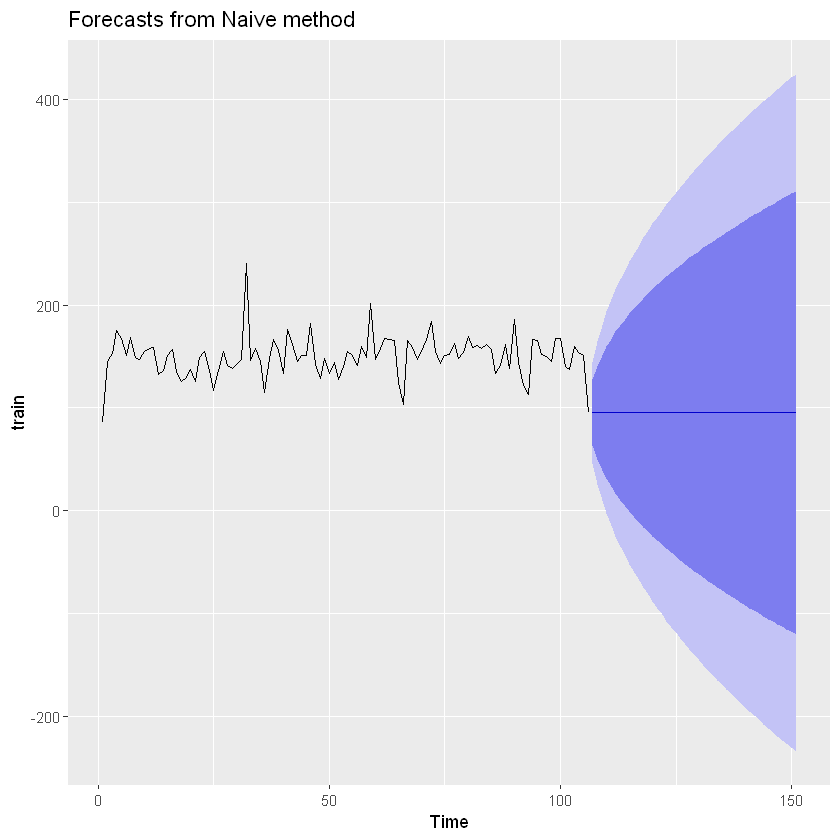

In [49]:
autoplot(forecast(naive_mod,h=45))

# Simple exoponential smoothing

In [50]:
se_model <- ses(train, h = 45)
summary(se_model)


Forecast method: Simple exponential smoothing

Model Information:
Simple exponential smoothing 

Call:
 ses(y = train, h = 45) 

  Smoothing parameters:
    alpha = 1e-04 

  Initial states:
    l = 149.8494 

  sigma:  19.9525

     AIC     AICc      BIC 
1132.897 1133.132 1140.887 

Error measures:
                      ME    RMSE      MAE       MPE     MAPE      MASE
Training set 0.005259236 19.7634 13.75746 -1.850195 9.675798 0.7729382
                  ACF1
Training set 0.1175613

Forecasts:
    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
107       149.8495 124.2793 175.4197 110.7433 188.9557
108       149.8495 124.2793 175.4197 110.7433 188.9557
109       149.8495 124.2793 175.4197 110.7433 188.9557
110       149.8495 124.2793 175.4197 110.7433 188.9557
111       149.8495 124.2793 175.4197 110.7433 188.9557
112       149.8495 124.2793 175.4197 110.7433 188.9557
113       149.8495 124.2793 175.4197 110.7433 188.9557
114       149.8495 124.2793 175.4197 110.7433 188.9557
11

### Check residuals


	Ljung-Box test

data:  Residuals from Simple exponential smoothing
Q* = 10.061, df = 8, p-value = 0.2608

Model df: 2.   Total lags used: 10



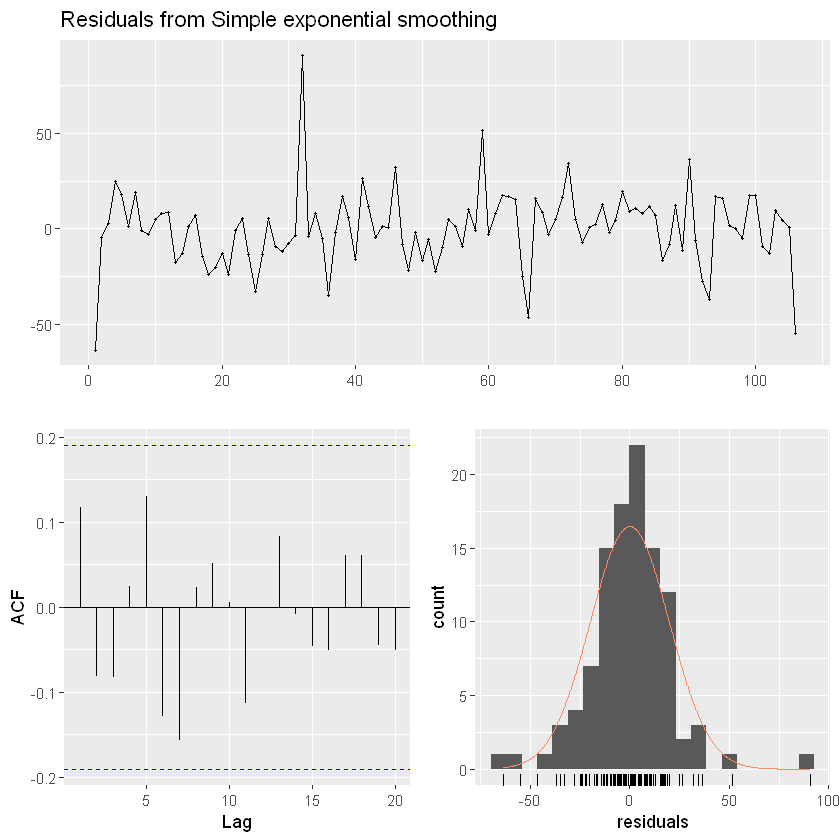

In [51]:
checkresiduals(se_model)

In [52]:
shapiro.test(se_model$residuals)


	Shapiro-Wilk normality test

data:  se_model$residuals
W = 0.93088, p-value = 3.382e-05


The ACF plot of the residuals from the simple exponential smoothing model shows that all autocorrelations are within the threshold limits, indicating that the residuals are behaving like white noise. A portmanteau test returns a p -value of 0.2986, which is larger than the significance level of 0.05  also suggesting that the residuals are white noise.

Still obtain a small p-value suggesting that the residuals are not normally distributed. Forecasts from this model will probably be quite good, but prediction intervals that are computed assuming a normal distribution may be inaccurate.

### Forecast

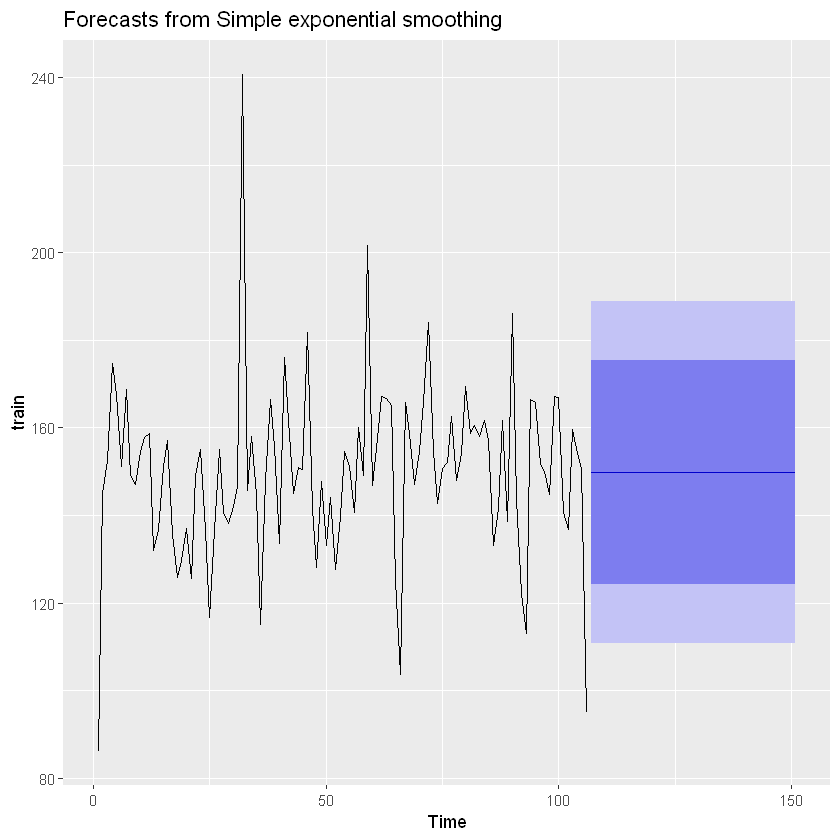

In [53]:
autoplot(se_model)

# Holt's trend method

In [54]:
holt_model <- holt(train, h = 45)
summary(holt_model)


Forecast method: Holt's method

Model Information:
Holt's method 

Call:
 holt(y = train, h = 45) 

  Smoothing parameters:
    alpha = 1e-04 
    beta  = 1e-04 

  Initial states:
    l = 141.5899 
    b = 0.1212 

  sigma:  20.312

     AIC     AICc      BIC 
1138.624 1139.224 1151.941 

Error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE      ACF1
Training set 1.223427 19.92506 13.81832 -0.9884767 9.633929 0.7763575 0.1281527

Forecasts:
    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
107       156.1029 130.0720 182.1337 116.2921 195.9136
108       156.2370 130.2062 182.2679 116.4262 196.0478
109       156.3712 130.3403 182.4020 116.5604 196.1819
110       156.5053 130.4744 182.5362 116.6945 196.3161
111       156.6395 130.6086 182.6703 116.8287 196.4502
112       156.7736 130.7427 182.8045 116.9628 196.5844
113       156.9078 130.8769 182.9386 117.0970 196.7185
114       157.0419 131.0110 183.0728 117.2311 196.8527
115       157.1761 131.14

### Check residuals


	Ljung-Box test

data:  Residuals from Holt's method
Q* = 9.9964, df = 6, p-value = 0.1248

Model df: 4.   Total lags used: 10



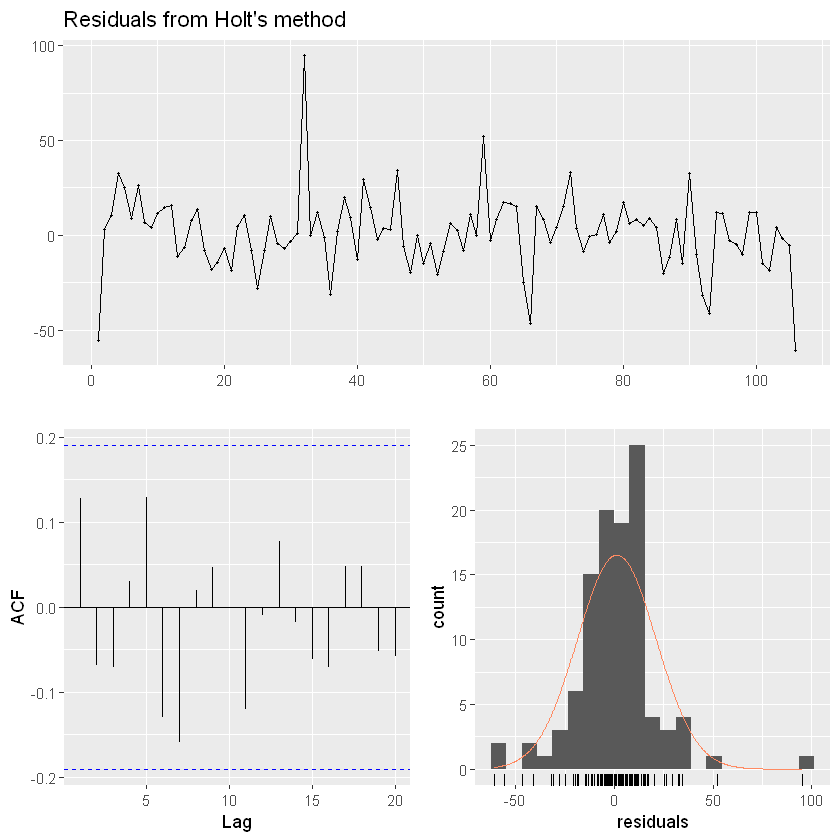

In [55]:
checkresiduals(holt_model)

In [56]:
shapiro.test(holt_model$residuals)


	Shapiro-Wilk normality test

data:  holt_model$residuals
W = 0.92034, p-value = 8.528e-06


The ACF plot of the residuals from the Holt's model shows that all autocorrelations are within the threshold limits, indicating that the residuals are behaving like white noise. A portmanteau test returns a p -value of 0.1258, which is larger than the significance level of 0.05  also suggesting that the residuals are white noise.

Still obtain a small p-value suggesting that the residuals are not normally distributed. Forecasts from this model will probably be quite good, but prediction intervals that are computed assuming a normal distribution may be inaccurate.

### Forecast

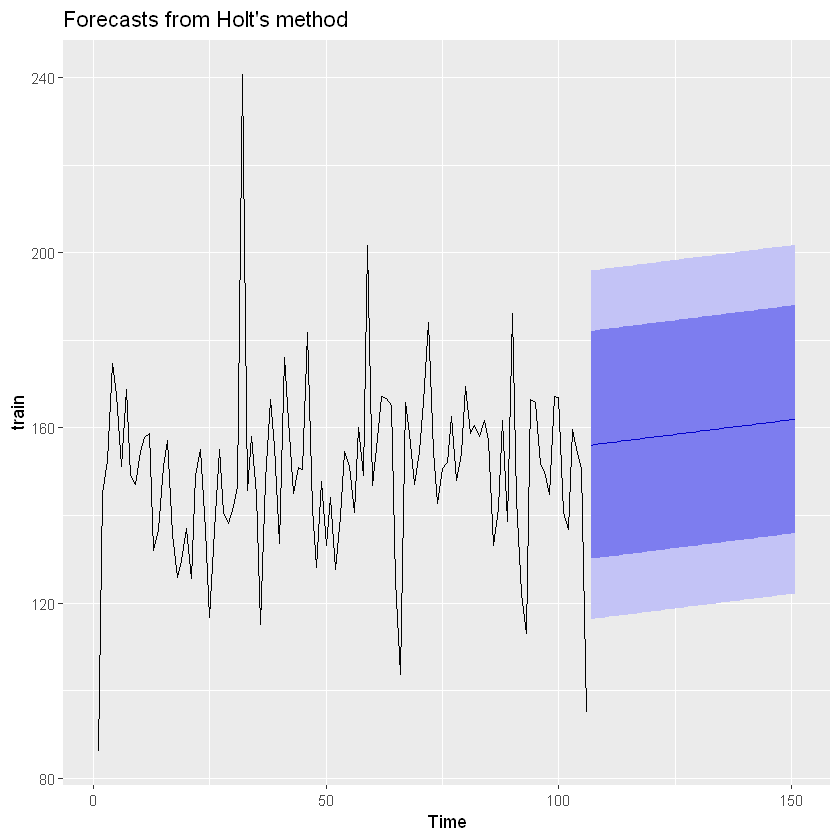

In [57]:
autoplot(holt_model)

# Linear regression

In [58]:
train_ts <- ts(as.numeric(train), frequency=7)

In [59]:
linear_model <- tslm(train_ts~season+trend)
summary(linear_model)


Call:
tslm(formula = train_ts ~ season + trend)

Residuals:
    Min      1Q  Median      3Q     Max 
-51.705 -10.977   0.524  10.214  83.734 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 137.74235    5.98663  23.008   <2e-16 ***
season2       7.32047    7.11785   1.028   0.3063    
season3       9.52144    7.11674   1.338   0.1840    
season4      17.70523    7.11618   2.488   0.0145 *  
season5       9.22845    7.11618   1.297   0.1977    
season6      13.02841    7.11674   1.831   0.0702 .  
season7       9.53175    7.11785   1.339   0.1836    
trend         0.05085    0.06294   0.808   0.4211    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 19.8 on 98 degrees of freedom
Multiple R-squared:  0.07194,	Adjusted R-squared:  0.005651 
F-statistic: 1.085 on 7 and 98 DF,  p-value: 0.3787


### Check residuals


	Breusch-Godfrey test for serial correlation of order up to 14

data:  Residuals from Linear regression model
LM test = 14.83, df = 14, p-value = 0.3899


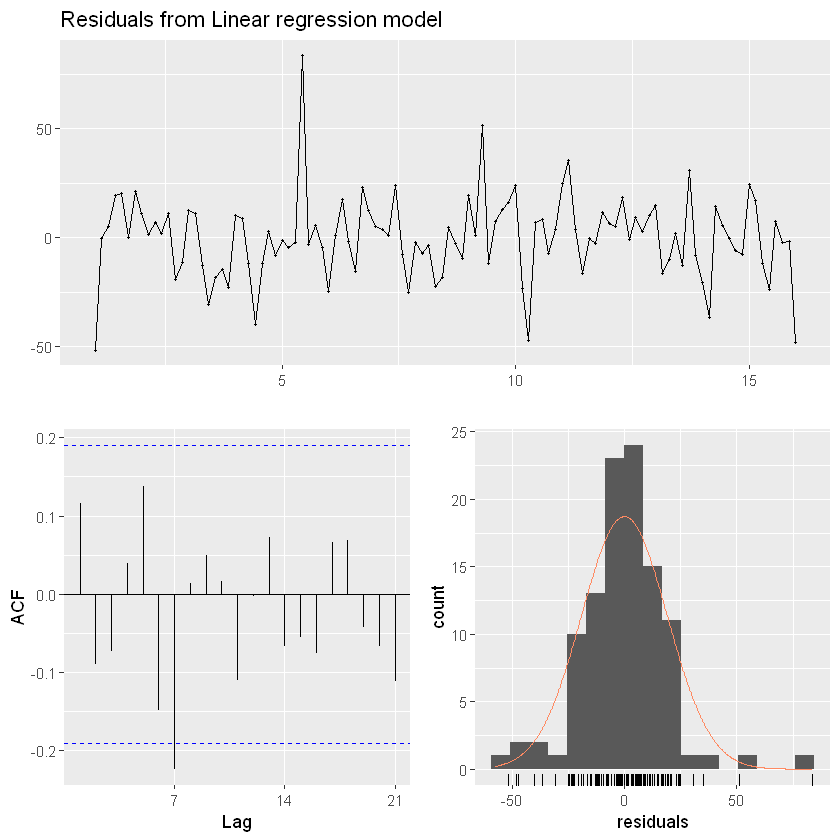

In [60]:
checkresiduals(linear_model)

In [61]:
shapiro.test(linear_model$residuals)


	Shapiro-Wilk normality test

data:  linear_model$residuals
W = 0.94916, p-value = 0.0004822


The ACF plot of the residuals from the simple exponential smoothing model shows that most autocorrelations are within the threshold limits, indicating that the residuals are behaving like white noise. Breusch-Godfrey test returns a p -value of 0.4065, which is larger than the significance level of 0.05 also suggesting that the residuals are white noise.

Still obtain a small p-value suggesting that the residuals are not normally distributed. Forecasts from this model will probably be quite good, but prediction intervals that are computed assuming a normal distribution may be inaccurate.

### Forecast

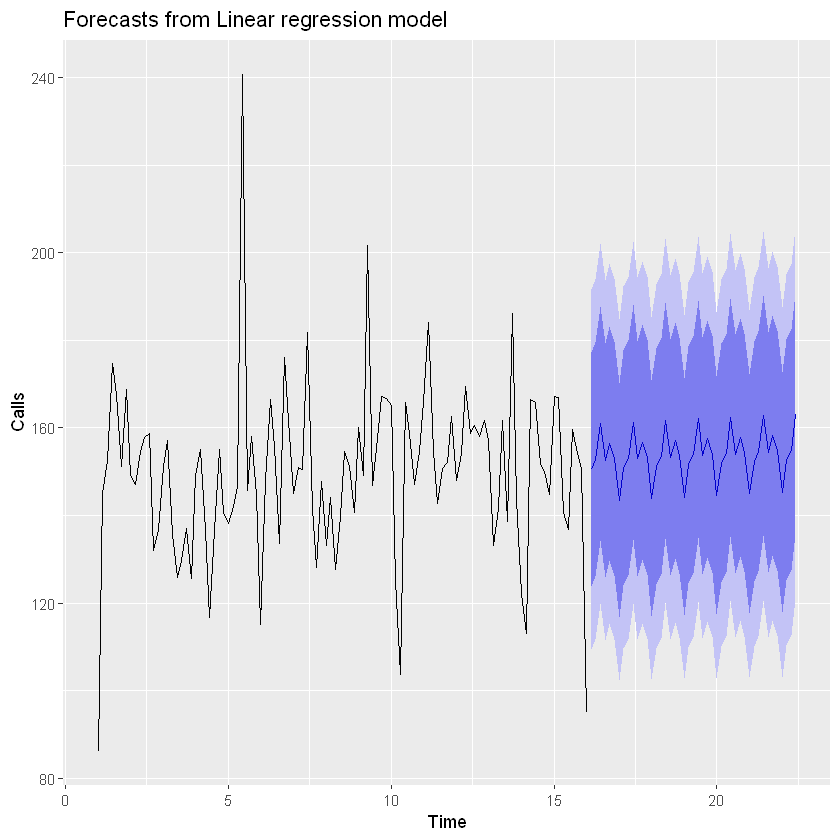

In [62]:
linear_forecast <- forecast(linear_model,h=45)
autoplot(linear_forecast)+ xlab("Time") + ylab("Calls")

# Summary of errror statistics- training

In [63]:
Metric <- c('MSE','MAPE')
ARIMA <- c(accuracy(AR)[2]^2,accuracy(AR)[5])
Naive <- c(accuracy(naive_mod)[2]^2,accuracy(naive_mod)[5])
SE <- c(accuracy(se_model)[2]^2,accuracy(se_model)[5])
Holt <- c(accuracy(holt_model)[2]^2,accuracy(holt_model)[5])
Linear_regression <- c(accuracy(linear_model)[2]^2,accuracy(linear_model)[5])

In [64]:
data.frame(Metric,ARIMA,Naive,SE,Holt,Linear_regression)

Metric,ARIMA,Naive,SE,Holt,Linear_regression
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MSE,382.544004,628.55067,390.592015,397.007857,362.456246
MAPE,9.575325,11.93192,9.675798,9.633929,9.541291


# Error statistics on the test data

In [65]:
test_df <-data.frame(test)
Metric <- c('MAPE','MSE')

#Forecasting Arima
fore_arima <- forecast::forecast(AR, h=45)
df_arima <- as.data.frame(fore_arima)
test_df$arima <- df_arima$`Point Forecast`


ARIMA<-c(MAPE(test_df$arima,test_df$test),MSE(test_df$arima,test_df$test))

In [66]:
#Forecasting se model
fore_se <- forecast::forecast(se_model, h=45)
df_se <- as.data.frame(fore_se)
test_df$se <- df_se$`Point Forecast`

SE <-c(MAPE(test_df$se,test_df$test),MSE(test_df$se,test_df$test))

In [67]:
#Forecasting Naive
fore_naive <- forecast::forecast(naive_mod, h=45)
df_naive <- as.data.frame(fore_naive)
test_df$naive <- df_naive$`Point Forecast`

Naive <-c(MAPE(test_df$naive,test_df$test),MSE(test_df$naive,test_df$test))

In [68]:
#Forecasting holt
fore_holt <- forecast::forecast(holt_model, h=45)
df_holt <- as.data.frame(fore_holt)
test_df$holt <- df_holt$`Point Forecast`

Holt <- c(MAPE(test_df$holt,test_df$test),MSE(test_df$holt,test_df$test))

In [69]:
#Forecasting linear
fore_linear <- forecast::forecast(linear_model, h=45)
df_linear <- as.data.frame(fore_linear)
test_df$linear <- df_linear$`Point Forecast`

Linear_Regression <- c(MAPE(test_df$linear,test_df$test),MSE(test_df$linear,test_df$test))

In [70]:
data.frame(Metric,ARIMA,Naive,SE,Holt,Linear_Regression)

Metric,ARIMA,Naive,SE,Holt,Linear_Regression
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MAPE,0.2183842,0.3296079,0.220523,0.2403609,0.2455438
MSE,1106.4285837,3862.3253577,1119.584593,1237.1754781,1289.1123214


# Box- Cox

Apply the box-cox transformation to try to fix the normallity of the residuals

[1] 0.2948381

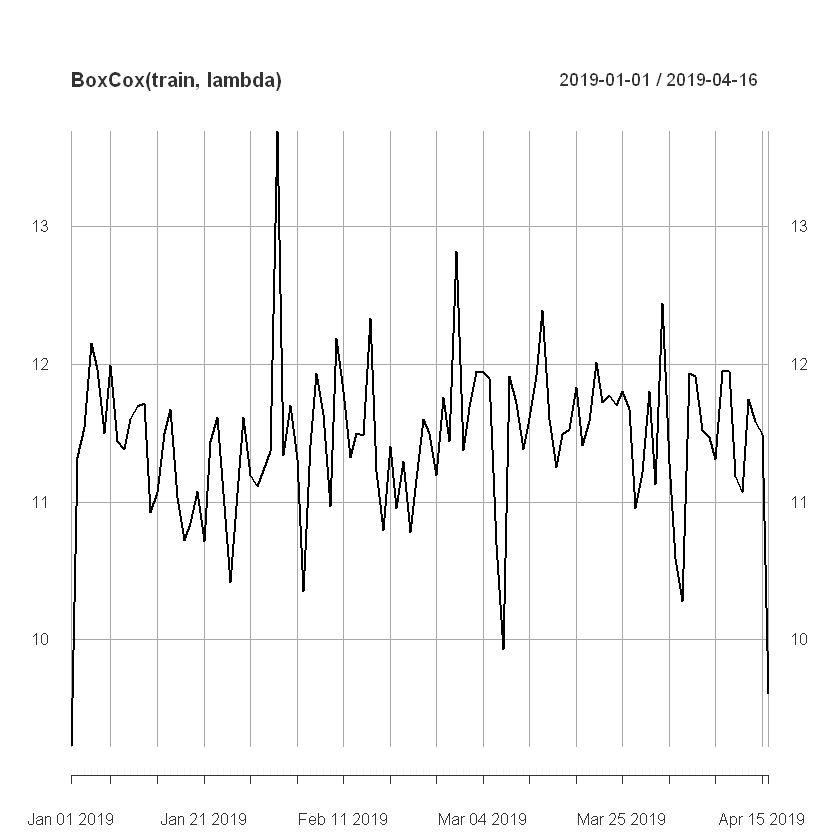

In [71]:
lambda <- BoxCox.lambda(train)
lambda
plot(BoxCox(train,lambda))

In [72]:
# apply transformation to training data
train <- BoxCox(train,lambda)


# Auto arima

In [73]:
arima_model <- auto.arima(train,approximation=FALSE,trace=TRUE,stepwise=FALSE)#,max.p = 7,max.q = 5,max.d = 2)
summary(arima_model)



 ARIMA(0,0,0) with zero mean     : 819.7313
 ARIMA(0,0,0) with non-zero mean : 190.8335
 ARIMA(0,0,1) with zero mean     : Inf
 ARIMA(0,0,1) with non-zero mean : 189.9319
 ARIMA(0,0,2) with zero mean     : 586.1343
 ARIMA(0,0,2) with non-zero mean : 191.5732
 ARIMA(0,0,3) with zero mean     : 513.6615
 ARIMA(0,0,3) with non-zero mean : 193.2423
 ARIMA(0,0,4) with zero mean     : 458.465
 ARIMA(0,0,4) with non-zero mean : 194.6341
 ARIMA(0,0,5) with zero mean     : 433.0337
 ARIMA(0,0,5) with non-zero mean : 194.7562
 ARIMA(1,0,0) with zero mean     : Inf
 ARIMA(1,0,0) with non-zero mean : 190.5808
 ARIMA(1,0,1) with zero mean     : Inf
 ARIMA(1,0,1) with non-zero mean : 191.8139
 ARIMA(1,0,2) with zero mean     : Inf
 ARIMA(1,0,2) with non-zero mean : 193.1593
 ARIMA(1,0,3) with zero mean     : Inf
 ARIMA(1,0,3) with non-zero mean : 195.3369
 ARIMA(1,0,4) with zero mean     : Inf
 ARIMA(1,0,4) with non-zero mean : 195.8367
 ARIMA(2,0,0) with zero mean     : Inf
 ARIMA(2,0,0) with non-

## Arima fit


Call:
arima(x = train, order = c(0, 0, 1))

Coefficients:
         ma1  intercept
      0.2086    11.4285
s.e.  0.1142     0.0676

sigma^2 estimated as 0.3311:  log likelihood = -91.85,  aic = 189.7


Warning message in eval(expr, envir, enclos):
"Incompatible methods ("Ops.xts", "Ops.ts") for "-""

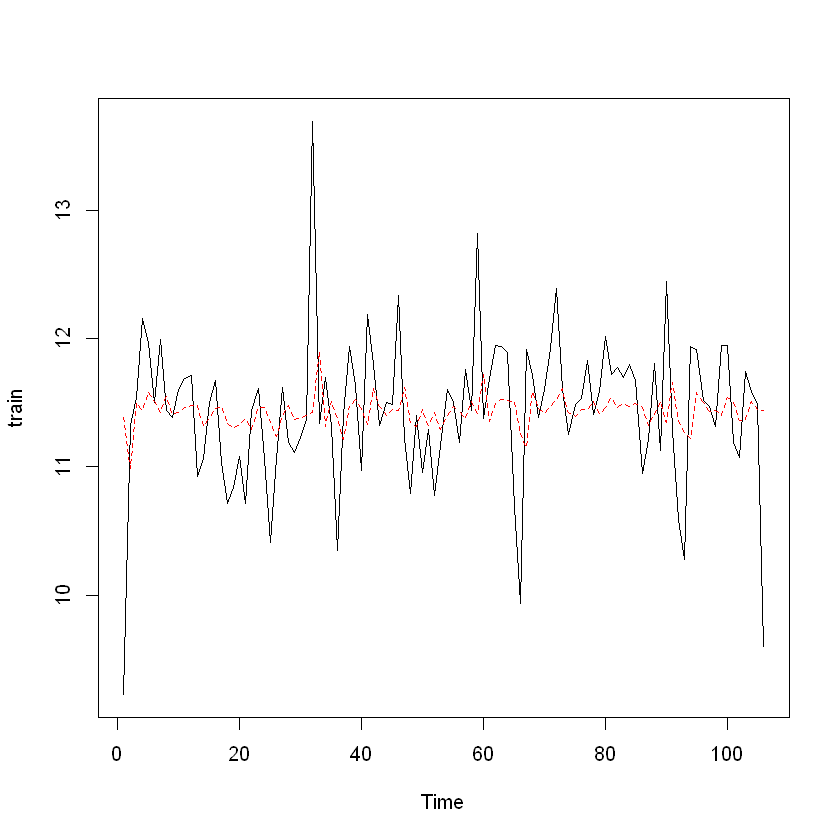

In [74]:
# Fit the AR model to time series
AR <- arima(train,order=c(0,0,1))
print(AR)

# Run the following commands to plot the series and fitted values
ts.plot(train)
AR_fitted <- train - residuals(AR)
points(AR_fitted, type = "l", col = 2, lty = 2)

## residuals


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with non-zero mean
Q* = 7.8438, df = 8, p-value = 0.4489

Model df: 2.   Total lags used: 10



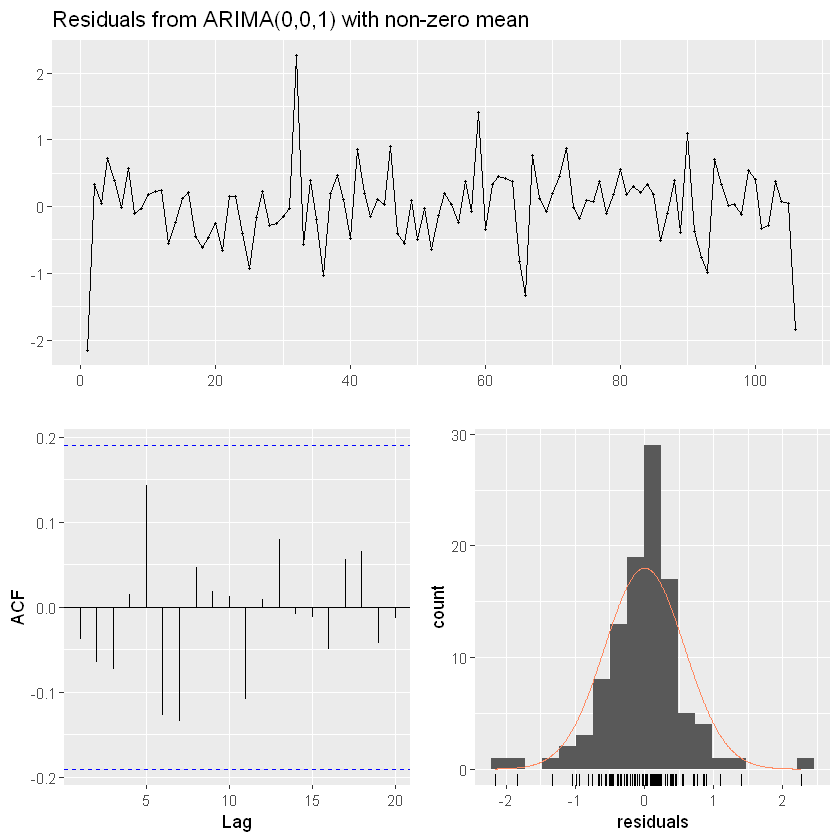

In [75]:
checkresiduals(AR)


In [76]:
shapiro.test(AR$residuals)


	Shapiro-Wilk normality test

data:  AR$residuals
W = 0.93816, p-value = 9.316e-05


In [77]:
#Forecasting Arima
fore_arima <- forecast::forecast(AR, h=45,lambda=lambda)
df_arima <- as.data.frame(fore_arima)
test_df$arima <- df_arima$`Point Forecast`


MAPE(test_df$arima,test_df$test)
MSE(test_df$arima,test_df$test)

Warning message in InvBoxCox(pred$pred, lambda, biasadj, pred$se^2):
"biasadj information not found, defaulting to FALSE."

[1] 0.2158849

[1] 1100.053

The ACF plot of the residuals from the ARIMA(0,0,1) model shows that all autocorrelations are within the threshold limits, indicating that the residuals are behaving like white noise. A portmanteau test returns a p -value of 0.4879, which is larger than the significance level of 0.05  also suggesting that the residuals are white noise.

Still obtain a small p-value suggesting that the residuals are not normally distributed. I will use the data without a box-cox transforamtion for the forecast

# 7 day forecasts

Fit the ARIMA model on the train + test and then forecast 7 days.


Call:
arima(x = time_series, order = c(0, 0, 1))

Coefficients:
         ma1  intercept
      0.2547   148.8022
s.e.  0.0832     2.0823

sigma^2 estimated as 416.9:  log likelihood = -669.78,  aic = 1345.55


Warning message in eval(expr, envir, enclos):
"Incompatible methods ("Ops.xts", "Ops.ts") for "-""

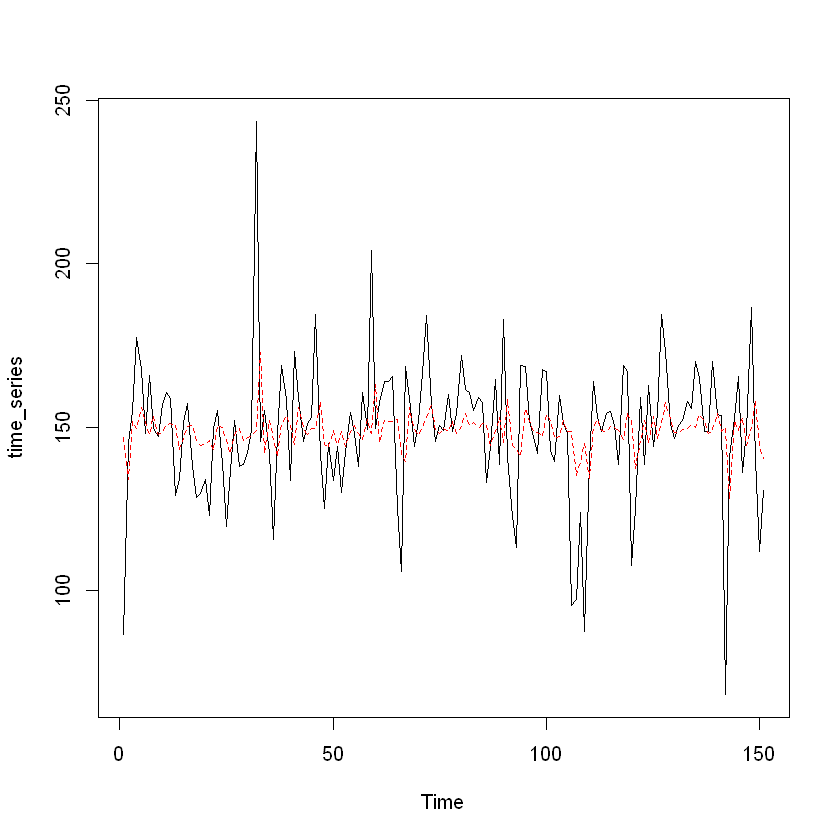

In [78]:
# Fit the AR model to time series
AR <- arima(time_series,order=c(0,0,1))
print(AR)

# Run the following commands to plot the series and fitted values
ts.plot(time_series)
AR_fitted <- time_series - residuals(AR)
points(AR_fitted, type = "l", col = 2, lty = 2)


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with non-zero mean
Q* = 8.4671, df = 8, p-value = 0.3892

Model df: 2.   Total lags used: 10



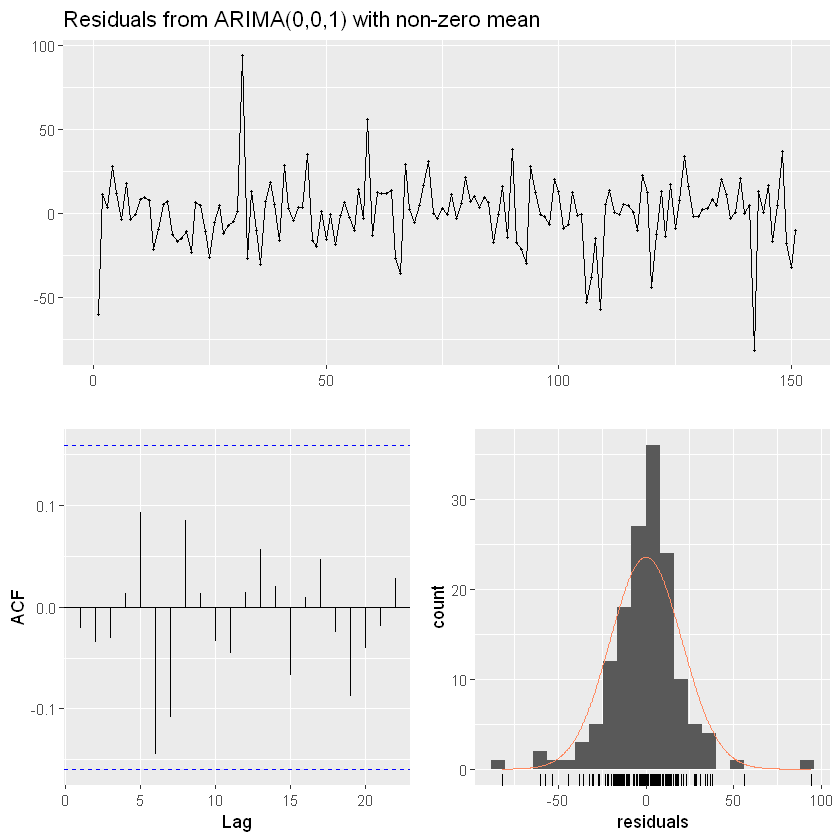

In [79]:
checkresiduals(AR)

In [80]:
shapiro.test(AR$residuals)


	Shapiro-Wilk normality test

data:  AR$residuals
W = 0.93049, p-value = 9.99e-07


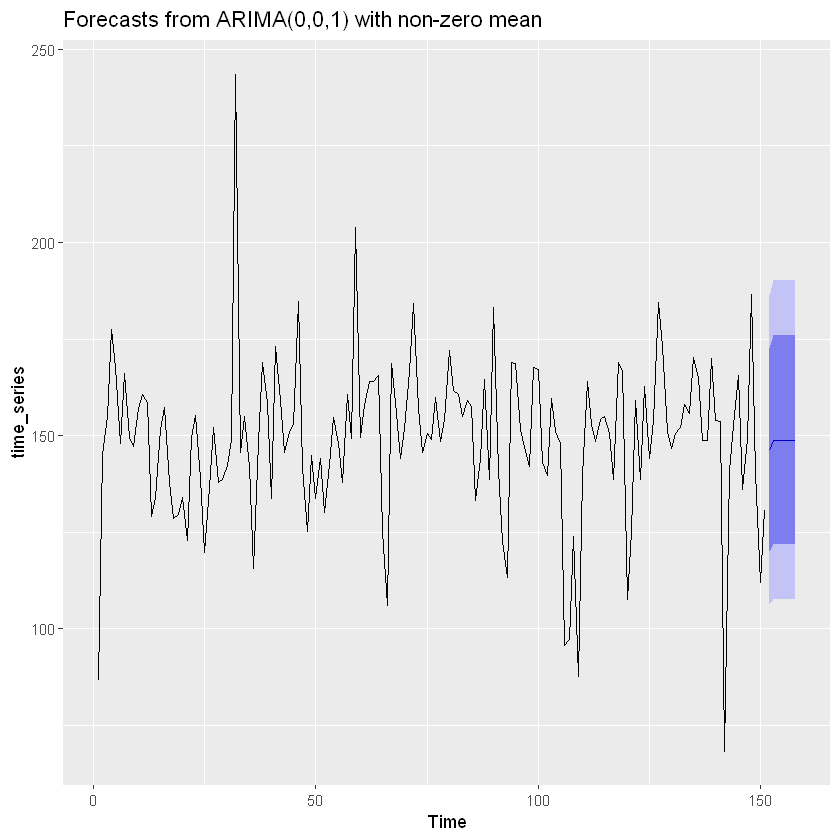

In [81]:
for_AR <- forecast(AR,h=7)
autoplot(for_AR)

In [82]:
forecast(AR,h=7)

    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
152       146.2590 120.0916 172.4265 106.2393 186.2787
153       148.8022 121.7994 175.8050 107.5050 190.0995
154       148.8022 121.7994 175.8050 107.5050 190.0995
155       148.8022 121.7994 175.8050 107.5050 190.0995
156       148.8022 121.7994 175.8050 107.5050 190.0995
157       148.8022 121.7994 175.8050 107.5050 190.0995
158       148.8022 121.7994 175.8050 107.5050 190.0995